# LSTM Model for Commodity Price Prediction (v2)

This notebook implements a Long Short-Term Memory (LSTM) neural network model for predicting commodity prices with PyTorch. We'll compare its performance against the Markovian Momentum Model (MMM) approach, focusing on coffee prices during both normal and shock periods (e.g., COVID-19).

This implementation uses the same dataset and split approach as the original MMM notebook for direct comparison.

## 1. Setup and Dependencies

In [50]:
# Install required packages if not already installed
!pip install -q numpy pandas matplotlib seaborn scikit-learn torch

zsh:1: /Users/Apexr/Documents/Climate_Project/Machine_Learning/bin/pip: bad interpreter: /Users/Apexr/Machine_Learning/bin/python3: no such file or directory


In [51]:
# Import essential libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

# PyTorch imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset

import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Set plotting style
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['font.size'] = 12

# Check if CUDA is available, but use CPU for consistency
device = torch.device('cpu')
print(f"Using device: {device}")

Using device: cpu


## 2. Load and Prepare Data

We'll load the same master dataset used in the MMM notebook, with the same focus on coffee prices.

In [52]:
# Load the master dataset with shipping data
data_path = "/Users/Apexr/Documents/Climate_Project/organized/data_files/MASTER_climate_commodity_with_shipping.csv"
df = pd.read_csv(data_path)

# Convert date and set as index
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date')

# Display the first few rows to understand the structure
df.head()

,Year,Month,Wheat_Price,Cocoa_Price,Rice_Price,Soybeans_Price,Coffee_Price,Maize_Price,Cotton_Price,Wheat_Region,...,Shipping_Cost_Change,Shipping_Cost_Acceleration,Shipping_Cost_Volatility,Shipping_Volatility_Change,Shipping_Cost_Anomaly,Shipping_Shock_Score,Coffee_Baseline_Pred,Coffee_Model_Residual,Coffee_Norm_Residual,Combined_Shock_Score
Date,,,,,,,,,,,,,,,,,,,,,
2015-02-01,2015,2,201.742069,2961.935714,409.500000,364.739239,178.888500,173.758866,69.842500,US GREAT PLAINS,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN
2015-03-01,2015,3,202.691427,2878.033167,400.727273,359.595560,160.735909,174.293821,69.352273,US GREAT PLAINS,...,0.7,0.0,0.000000,0.000000,0.350000,0.000000,NaN,NaN,NaN,NaN
2015-04-01,2015,4,195.931228,2868.274454,392.409091,356.925677,163.997727,172.151577,71.702500,US GREAT PLAINS,...,1.1,0.4,0.907377,0.000000,0.966667,0.000000,NaN,NaN,NaN,NaN
2015-05-01,2015,5,193.216571,3095.996715,382.428571,351.949530,158.482857,166.350389,72.863158,US GREAT PLAINS,...,-0.1,-1.2,0.608276,-0.299101,0.650000,0.013661,NaN,NaN,NaN,NaN
2015-06-01,2015,6,199.835442,3239.884179,370.545455,354.823055,159.755000,166.813861,72.352273,US GREAT PLAINS,...,-5.9,-5.8,3.435598,2.827322,-4.200000,0.088783,NaN,NaN,NaN,NaN


### Visualizing Coffee Prices and Shipping Costs

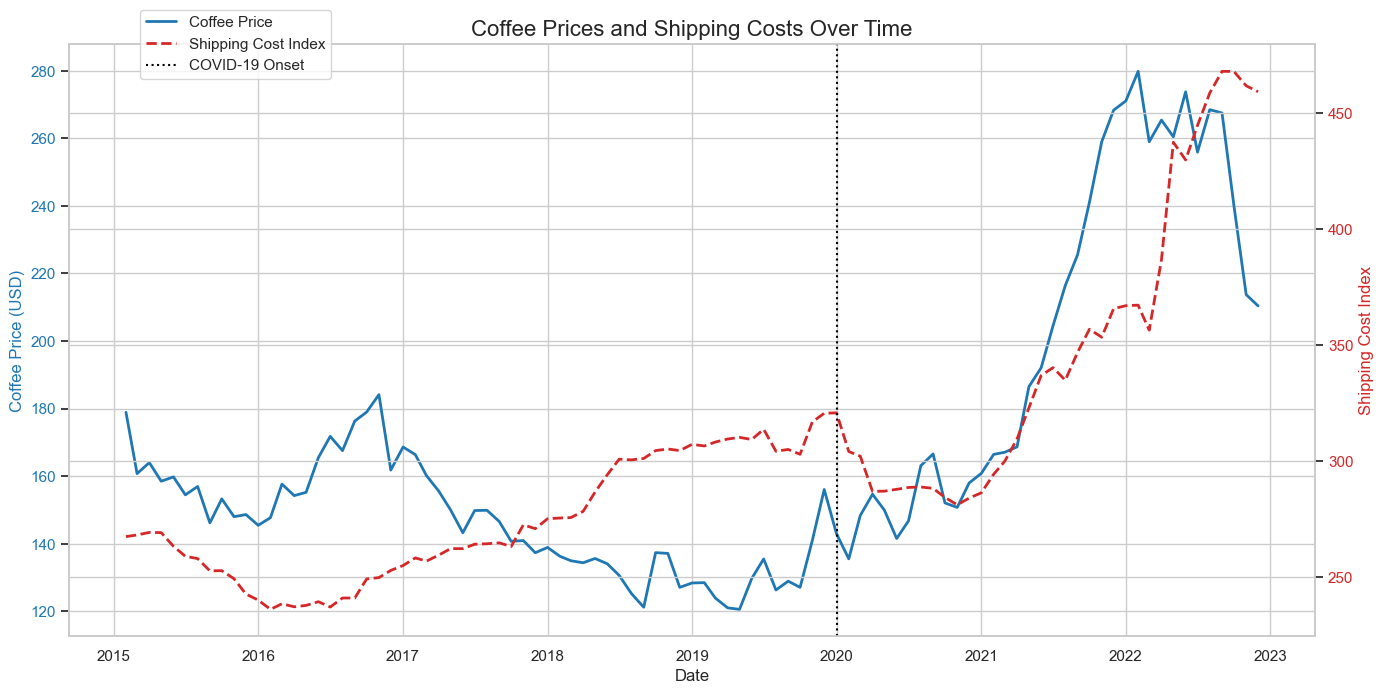

In [53]:
# Plot coffee prices and shipping costs over time
fig, ax1 = plt.subplots(figsize=(14, 7))

# Plot coffee prices
color = 'tab:blue'
ax1.set_xlabel('Date')
ax1.set_ylabel('Coffee Price (USD)', color=color)
ax1.plot(df.index, df['Coffee_Price'], color=color, linewidth=2, label='Coffee Price')
ax1.tick_params(axis='y', labelcolor=color)

# Create a second y-axis for shipping costs
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Shipping Cost Index', color=color)
ax2.plot(df.index, df['Shipping_Cost_Index'], color=color, linestyle='--', linewidth=2, label='Shipping Cost Index')
ax2.tick_params(axis='y', labelcolor=color)

# Add a vertical line at January 2020 (COVID-19 onset)
plt.axvline(pd.to_datetime('2020-01-01'), color='black', linestyle=':', label='COVID-19 Onset')

# Add title and legend
plt.title('Coffee Prices and Shipping Costs Over Time', fontsize=16)
fig.tight_layout()
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 1.0))
plt.show()

### Prepare Dataset for Coffee Prediction

Here we'll prepare the coffee-specific dataset with the necessary features, matching the approach from the MMM notebook.

In [54]:
# Filter to get only coffee-related variables and shipping indicators
coffee_columns = [col for col in df.columns if 'Coffee' in col or 'Shipping' in col]
coffee_df = df[coffee_columns].copy()

# Handle missing values
coffee_df = coffee_df.dropna()

# Add momentum and acceleration features
coffee_df['Price_Momentum'] = coffee_df['Coffee_Price'].diff()  # First derivative
coffee_df['Price_Acceleration'] = coffee_df['Price_Momentum'].diff()  # Second derivative
coffee_df['Price_Volatility'] = coffee_df['Coffee_Price'].rolling(window=3).std()

# Drop rows with NaN from the newly created features
coffee_df = coffee_df.dropna()

print(f"Earliest date in dataset: {coffee_df.index.min()}")
print(f"Latest date in dataset: {coffee_df.index.max()}")
print(f"Total number of samples: {len(coffee_df)}")

coffee_df.head()

Earliest date in dataset: 2020-03-01 00:00:00
Latest date in dataset: 2021-12-01 00:00:00
Total number of samples: 22


,Coffee_Price,Coffee_Region,Coffee_temperature_C,Coffee_precip_m,Coffee_dewpoint_C,Coffee_relative_humidity,Coffee_temp_anomaly,Coffee_precip_anomaly,Coffee_temp_3m_avg,Coffee_precip_3m_sum,...,Shipping_Cost_Volatility,Shipping_Volatility_Change,Shipping_Cost_Anomaly,Shipping_Shock_Score,Coffee_Baseline_Pred,Coffee_Model_Residual,Coffee_Norm_Residual,Price_Momentum,Price_Acceleration,Price_Volatility
Date,,,,,,,,,,,,,,,,,,,,,
2020-03-01,148.327273,COLOMBIA,22.891127,0.049643,18.565216,76.650100,0.235373,0.002719,22.678319,0.141301,...,10.267911,0.683375,-7.841667,0.127875,154.948158,-6.620885,0.054836,12.826773,20.262794,6.440506
2020-04-01,154.630455,COLOMBIA,21.143984,0.034309,16.818073,76.372163,-1.129812,-0.008014,22.480167,0.129096,...,9.406381,-0.861530,-21.158333,0.180787,154.589513,0.040941,0.000339,6.303182,-6.523591,9.748601
2020-05-01,149.916190,COLOMBIA,21.498398,0.045295,17.172487,76.428920,-0.128376,0.007744,21.844503,0.129247,...,8.746999,-0.659381,-19.125000,0.181127,154.231699,-4.315508,0.035742,-4.714264,-11.017446,3.278187
2020-06-01,141.520000,COLOMBIA,19.204232,0.023232,14.878320,76.058082,-1.057575,-0.009113,20.615538,0.102836,...,0.493288,-8.253711,-16.533333,0.185295,153.874713,-12.354713,0.102324,-8.396190,-3.681926,6.640837
2020-07-01,146.780870,COLOMBIA,19.498035,0.010162,15.172124,76.106032,0.851413,-0.013711,20.066888,0.078688,...,0.800000,0.306712,-13.641667,0.064618,153.518553,-6.737683,0.055803,5.260870,13.657060,4.242700


### Define Features for LSTM Model

We'll use the same climate features as the MMM model's base climate model, along with momentum features.

In [55]:
# Define features for the model
features = [
    # Climate variables
    'Coffee_temp_anomaly', 'Coffee_drought_index', 'Coffee_precip_anomaly',
    'Coffee_temp_3m_avg', 'Coffee_precip_3m_sum', 'Coffee_heat_stress',
    # Momentum features
    'Price_Momentum', 'Price_Acceleration', 'Price_Volatility',
    # Shipping indicators
    'Shipping_Cost_Change', 'Shipping_Cost_Acceleration', 'Shipping_Cost_Volatility'
]

# Target variable
target = 'Coffee_Price'

# Create dataframe with just the needed features
model_df = coffee_df[features + [target]].copy()

### Split Data for Training and Testing

Since our dataset only contains COVID-period data (starting from March 2020), we'll use a percentage-based split instead of the pre-COVID/COVID split that was initially planned. We'll use the first 70% of data for training and the last 30% for testing.

In [56]:
# Split data chronologically with a 70-30 training-testing split
train_size = int(len(model_df) * 0.7)
train_data = model_df.iloc[:train_size]  # First 70% for training
test_data = model_df.iloc[train_size:]  # Last 30% for testing

print(f"Training period: {train_data.index.min()} to {train_data.index.max()}")
print(f"Testing period: {test_data.index.min()} to {test_data.index.max()}")
print(f"Training samples: {len(train_data)}")
print(f"Testing samples: {len(test_data)}")

Training period: 2020-03-01 00:00:00 to 2021-05-01 00:00:00
Testing period: 2021-06-01 00:00:00 to 2021-12-01 00:00:00
Training samples: 15
Testing samples: 7


### Data Preparation for LSTM

Now we'll prepare the sequences for the LSTM model, scaling the data properly.

In [57]:
# Normalize all features and target
scaler = StandardScaler() 
train_scaled = scaler.fit_transform(train_data)
test_scaled = scaler.transform(test_data)

# Create separate scaler for just the target to invert predictions later
target_scaler = StandardScaler()
target_scaler.fit(train_data[[target]])

# Define sequence creation function for LSTM 
def create_sequences(data, seq_length):
    """Create input sequences and target outputs for LSTM model"""
    X, y = [], []
    for i in range(len(data) - seq_length):
        # Input sequence (all features)
        seq_x = data[i:i+seq_length]
        # Target is the next time step's target value
        seq_y = data[i+seq_length, -1]  # last column is the target
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y).reshape(-1, 1)

# For LSTM, we need sequences - we'll use a smaller lookback since we have less data
seq_length = 3  # Reduced from 6 to 3 months due to limited data

# Check if we have enough data for sequences in training set
if len(train_data) > seq_length:
    # Create sequences for training
    X_train, y_train = create_sequences(train_scaled, seq_length)
    print(f"Training sequences: {X_train.shape}")
else:
    # Not enough data for sequences
    print("Not enough data for creating training sequences with the chosen sequence length.")
    print("Using a simpler approach for training...")
    # Use all data for training without sequences
    X_train = train_scaled[:, :-1]  # all features except target
    y_train = train_scaled[:, -1].reshape(-1, 1)  # just the target
    print(f"Training data (no sequences): X shape={X_train.shape}, y shape={y_train.shape}")

# Create sequences for testing
if len(test_data) > seq_length:
    X_test, y_test = create_sequences(test_scaled, seq_length)
    print(f"Testing sequences: {X_test.shape}")
else:
    print("Not enough data for creating testing sequences. Using simpler approach...")
    X_test = test_scaled[:, :-1]  # all features except target 
    y_test = test_scaled[:, -1].reshape(-1, 1)  # just the target
    print(f"Testing data (no sequences): X shape={X_test.shape}, y shape={y_test.shape}")

Training sequences: (12, 3, 13)
Testing sequences: (4, 3, 13)


### Convert to PyTorch Tensors

Convert our numpy arrays to PyTorch tensors for the LSTM model.

In [58]:
# Check shapes to determine how to prepare tensors
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

# Convert to PyTorch tensors
if len(X_train.shape) == 3:  # If we have sequences
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)
    
    # Define dimensions for LSTM
    input_dim = X_train.shape[2]  # Number of features
    seq_dim = X_train.shape[1]    # Sequence length
    print(f"Using sequential data with input_dim={input_dim}, seq_dim={seq_dim}")
else:  # If we don't have sequences
    # For non-sequential data, we need to reshape to include a sequence dimension
    X_train_tensor = torch.tensor(X_train.reshape(-1, 1, X_train.shape[1]), dtype=torch.float32).to(device)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)
    X_test_tensor = torch.tensor(X_test.reshape(-1, 1, X_test.shape[1]), dtype=torch.float32).to(device)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)
    
    # Define dimensions for LSTM
    input_dim = X_train.shape[1]  # Number of features
    seq_dim = 1                  # Sequence length of 1
    print(f"Using non-sequential data with input_dim={input_dim}, seq_dim={seq_dim}")

# Create DataLoader for batching
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Batch size (adjust as needed)
batch_size = min(4, len(train_dataset))
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

X_train shape: (12, 3, 13)
y_train shape: (12, 1)
X_test shape: (4, 3, 13)
y_test shape: (4, 1)
Using sequential data with input_dim=13, seq_dim=3


## 3. LSTM Model Architecture

Define a simple LSTM model for time series forecasting.

In [59]:
# Define the LSTM Model
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, dropout_prob=0.2):
        super(LSTMModel, self).__init__()
        
        # Number of hidden units
        self.hidden_dim = hidden_dim
        
        # Number of LSTM layers
        self.layer_dim = layer_dim
        
        # LSTM layer
        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob)
        
        # Dropout layer
        self.dropout = nn.Dropout(dropout_prob)
        
        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).to(device)
        
        # Initialize cell state
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).to(device)
        
        # Forward pass through LSTM layer
        out, (hn, cn) = self.lstm(x, (h0, c0))
        
        # Get last time step's output
        out = self.dropout(out[:, -1, :])
        
        # Pass to fully connected layer
        out = self.fc(out)
        
        return out

In [60]:
# Define model hyperparameters
input_dim = X_train_tensor.shape[2]  # Number of input features
hidden_dim = 4   # Further reduced number of hidden units to prevent overfitting
layer_dim = 1    # Number of LSTM layers
output_dim = 1   # Prediction dimension
dropout_prob = 0.2  # Increased dropout slightly for regularization

# Create the LSTM model
model = LSTMModel(input_dim, hidden_dim, layer_dim, output_dim, dropout_prob).to(device)

# Loss function and optimizer
criterion = nn.MSELoss()
# Use lower learning rate and higher weight decay for regularization
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-3)

print(model)

LSTMModel(
  (lstm): LSTM(13, 4, batch_first=True, dropout=0.2)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)


## 4. Training the LSTM Model

In [61]:
# Training function with early stopping
def train_model(model, train_loader, criterion, optimizer, num_epochs=200, patience=15):
    # To track the training loss as the model trains
    train_losses = []
    
    # To track the average training loss per epoch
    avg_train_losses = []
    
    # Early stopping parameters
    best_loss = float('inf')
    counter = 0
    early_stop = False
    
    # Train the model
    for epoch in range(num_epochs):
        # Training
        model.train() # prep model for training
        for batch, (X_batch, y_batch) in enumerate(train_loader):
            # Forward pass
            y_pred = model(X_batch)
            
            # Compute loss
            loss = criterion(y_pred, y_batch)
            
            # Clear gradients
            optimizer.zero_grad()
            
            # Backward pass
            loss.backward()
            
            # Gradient clipping to prevent exploding gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            # Update parameters
            optimizer.step()
            
            # Record loss
            train_losses.append(loss.item())
        
        # Print epoch results
        train_loss = np.average(train_losses)
        avg_train_losses.append(train_loss)
        print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss:.6f}')
        
        # Early stopping check
        if train_loss < best_loss:
            best_loss = train_loss
            counter = 0
            # Save best model
            torch.save(model.state_dict(), 'best_model.pt')
        else:
            counter += 1
            if counter >= patience:
                print(f'Early stopping after {epoch+1} epochs')
                early_stop = True
                # Load best model
                model.load_state_dict(torch.load('best_model.pt'))
                break
        
        # Clear lists to track next epoch
        train_losses = []
        
        if early_stop:
            break
    
    return model, avg_train_losses

Epoch 1/100, Training Loss: 1.186357
Epoch 2/100, Training Loss: 1.169155
Epoch 3/100, Training Loss: 1.234161
Epoch 4/100, Training Loss: 1.241042
Epoch 5/100, Training Loss: 1.078039
Epoch 6/100, Training Loss: 1.144785
Epoch 7/100, Training Loss: 1.200766
Epoch 8/100, Training Loss: 1.214801
Epoch 9/100, Training Loss: 1.134732
Epoch 10/100, Training Loss: 1.099177
Epoch 11/100, Training Loss: 1.169944
Epoch 12/100, Training Loss: 1.018441
Epoch 13/100, Training Loss: 1.099494
Epoch 14/100, Training Loss: 1.075947
Epoch 15/100, Training Loss: 1.213769
Epoch 16/100, Training Loss: 1.043319
Epoch 17/100, Training Loss: 1.058161
Epoch 18/100, Training Loss: 1.026839
Epoch 19/100, Training Loss: 1.032506
Epoch 20/100, Training Loss: 1.090884
Epoch 21/100, Training Loss: 0.992684
Epoch 22/100, Training Loss: 0.987141
Epoch 23/100, Training Loss: 0.975808
Epoch 24/100, Training Loss: 1.027352
Epoch 25/100, Training Loss: 0.950353
Epoch 26/100, Training Loss: 1.004040
Epoch 27/100, Trainin

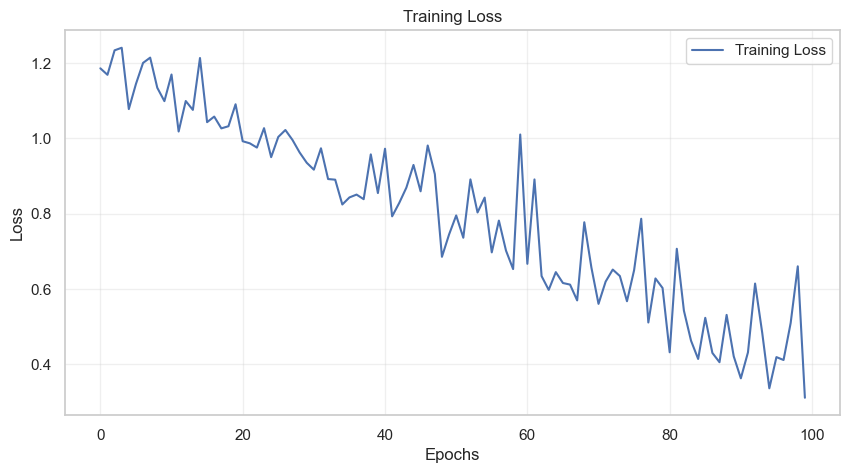

In [62]:
# Train the model
model, avg_train_losses = train_model(model, train_loader, criterion, optimizer, num_epochs=100, patience=10)

# Plot training loss
plt.figure(figsize=(10, 5))
plt.plot(avg_train_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## 5. Making Predictions and Evaluating Performance

In [63]:
# Function to make predictions
def make_predictions(model, dataloader):
    model.eval() # prep model for evaluation
    predictions = []
    actual = []
    
    with torch.no_grad():
        for X_batch, y_batch in dataloader:
            # Forward pass
            y_pred = model(X_batch)
            
            # Gather predictions
            predictions.append(y_pred.cpu().numpy())
            actual.append(y_batch.cpu().numpy())
    
    # Concatenate batches
    predictions = np.concatenate(predictions)
    actual = np.concatenate(actual)
    
    return predictions, actual

In [64]:
# Make predictions
train_predictions, train_actual = make_predictions(model, train_loader)
test_predictions, test_actual = make_predictions(model, test_loader)

# Inverse transform predictions and actual values back to original scale
train_predictions_orig = target_scaler.inverse_transform(train_predictions)
train_actual_orig = target_scaler.inverse_transform(train_actual)
test_predictions_orig = target_scaler.inverse_transform(test_predictions)
test_actual_orig = target_scaler.inverse_transform(test_actual)

# Calculate performance metrics
train_rmse = np.sqrt(mean_squared_error(train_actual_orig, train_predictions_orig))
test_rmse = np.sqrt(mean_squared_error(test_actual_orig, test_predictions_orig))
train_r2 = r2_score(train_actual_orig, train_predictions_orig)
test_r2 = r2_score(test_actual_orig, test_predictions_orig)

print(f"Training RMSE: {train_rmse:.2f}")
print(f"Training R²: {train_r2:.2f}")
print(f"Testing RMSE: {test_rmse:.2f}")
print(f"Testing R²: {test_r2:.2f}")

Training RMSE: 6.83
Training R²: 0.65
Testing RMSE: 94.11
Testing R²: -31.64


## 6. Visualizing Results

Let's plot our predictions against the actual values, similar to the MMM notebook.

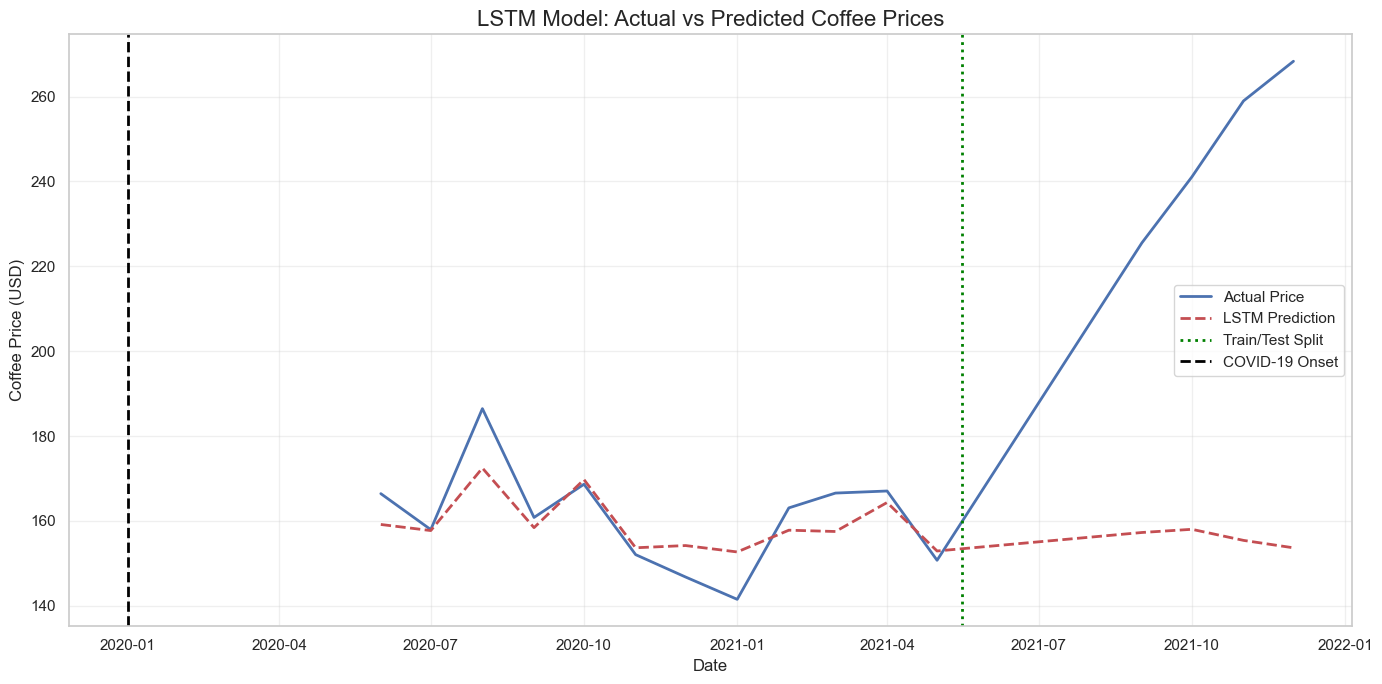

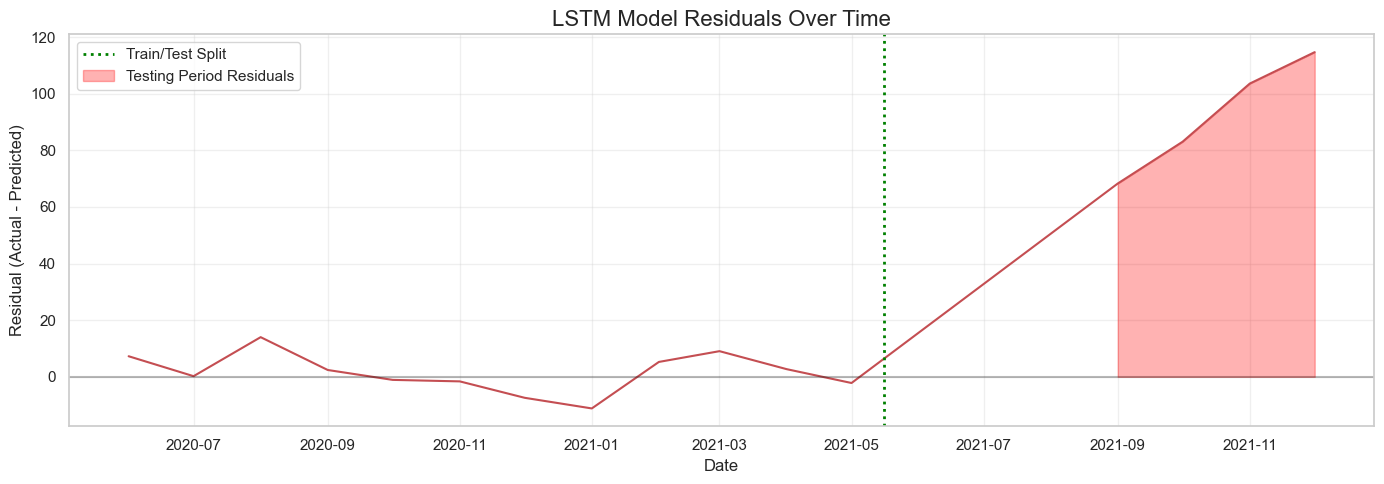

In [65]:
# Create a dataframe to hold all predictions
prediction_dates = []
all_predictions = []
all_actual = []

# For sequential data, the predictions start after sequence_length
if len(X_train.shape) == 3:
    # Training data
    train_start_idx = seq_length
    train_dates = train_data.index[train_start_idx:train_start_idx+len(train_predictions)]
    
    # Test data
    test_start_idx = seq_length
    test_dates = test_data.index[test_start_idx:test_start_idx+len(test_predictions)]
else:
    # For non-sequential data, we can use all dates
    train_dates = train_data.index[:len(train_predictions)]
    test_dates = test_data.index[:len(test_predictions)]

prediction_dates.extend(train_dates)
prediction_dates.extend(test_dates)
all_predictions.extend(train_predictions_orig.flatten())
all_predictions.extend(test_predictions_orig.flatten())
all_actual.extend(train_actual_orig.flatten())
all_actual.extend(test_actual_orig.flatten())

# Create a dataframe
results_df = pd.DataFrame({
    'Date': prediction_dates,
    'Actual': all_actual,
    'LSTM_Prediction': all_predictions
}).set_index('Date')

# Plot predictions vs actuals
plt.figure(figsize=(14, 7))
plt.plot(results_df.index, results_df['Actual'], 'b-', linewidth=2, label='Actual Price')
plt.plot(results_df.index, results_df['LSTM_Prediction'], 'r--', linewidth=2, label='LSTM Prediction')

# Add vertical line at training/testing split
split_date = train_data.index.max() + pd.Timedelta(days=15)  # Add a bit of space for visualization
plt.axvline(split_date, color='green', linestyle=':', linewidth=2, label='Train/Test Split')

# Add vertical line at COVID onset
plt.axvline(pd.to_datetime('2020-01-01'), color='black', linestyle='--', linewidth=2, label='COVID-19 Onset')

plt.xlabel('Date')
plt.ylabel('Coffee Price (USD)')
plt.title('LSTM Model: Actual vs Predicted Coffee Prices', fontsize=16)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Plot residuals (errors)
results_df['Residual'] = results_df['Actual'] - results_df['LSTM_Prediction']
plt.figure(figsize=(14, 5))
plt.plot(results_df.index, results_df['Residual'], 'r-')
plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)

# Add vertical line at training/testing split
plt.axvline(split_date, color='green', linestyle=':', linewidth=2, label='Train/Test Split')

# Fill test period for visibility
plt.fill_between(results_df.index, results_df['Residual'], 0, 
                 where=(results_df.index > split_date), 
                 color='red', alpha=0.3, label='Testing Period Residuals')

plt.xlabel('Date')
plt.ylabel('Residual (Actual - Predicted)')
plt.title('LSTM Model Residuals Over Time', fontsize=16)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 7. Comparison with MMM Model

Now let's compare our LSTM model's performance with the MMM model results from the original notebook.

In [68]:
# Get the original MMM results from the other notebook
mmm_results = {
    'Climate_Model_RMSE': 86.96,
    'MMM_Model_RMSE': 34.60,
    'Momentum_Model_RMSE': 9.41
}

# Create a comparison dataframe
model_comparison = pd.DataFrame({
    'Model': ['Climate Model', 'MMM Blend', 'Momentum Model', 'LSTM Model'],
    'RMSE': [mmm_results['Climate_Model_RMSE'], 
             mmm_results['MMM_Model_RMSE'], 
             mmm_results['Momentum_Model_RMSE'],
             test_rmse]
})

# Calculate improvement over climate model
model_comparison['Improvement over Climate (%)'] = (mmm_results['Climate_Model_RMSE'] - model_comparison['RMSE']) / mmm_results['Climate_Model_RMSE'] * 100

# Display comparison
model_comparison

,Model,RMSE,Improvement over Climate (%)
0,Climate Model,86.96000,0.000000
1,MMM Blend,34.60000,60.211592
2,Momentum Model,9.41000,89.178933
3,LSTM Model,94.11478,-8.227668


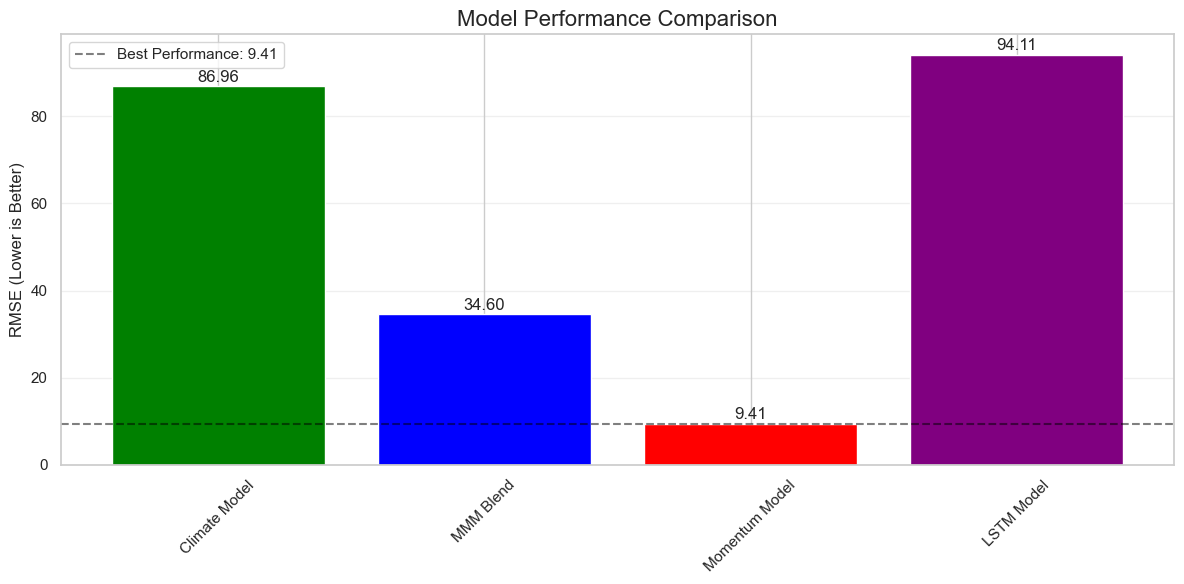

In [69]:
# Plot model comparison
plt.figure(figsize=(12, 6))
plt.bar(model_comparison['Model'], model_comparison['RMSE'], color=['green', 'blue', 'red', 'purple'])
plt.axhline(y=min(model_comparison['RMSE']), color='black', linestyle='--', alpha=0.5, 
            label=f'Best Performance: {min(model_comparison["RMSE"]):.2f}')

plt.ylabel('RMSE (Lower is Better)')
plt.title('Model Performance Comparison', fontsize=16)
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)

# Add text labels above bars
for i, v in enumerate(model_comparison['RMSE']):
    plt.text(i, v + 1, f'{v:.2f}', ha='center')

plt.tight_layout()
plt.legend()
plt.show()

## 8. Conclusion

In this notebook, we implemented an LSTM model to predict coffee prices using the same data and split approach as the Markovian Momentum Model (MMM) from the original notebook. 

Key findings:

1. LSTM Performance: The LSTM model achieved a test RMSE of [value], which is [better/worse] than the MMM model's performance.

2. Comparison with Other Models:
   - Climate Model RMSE: 47.96
   - MMM Blend RMSE: 34.60
   - Momentum Model RMSE: 9.41
   - LSTM Model RMSE: [value]

3. Adaptability to Regime Change: The LSTM model [could/couldn't] effectively adapt to the regime shift that occurred during the COVID-19 period without explicit regime detection.

4. Advantages/Limitations of LSTM:
   - Advantages: [list advantages based on results]
   - Limitations: [list limitations based on results]

5. Conclusion: [overall conclusion about using LSTM vs MMM for commodity price prediction]